In [24]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np

from deepxde.backend import tf
import matplotlib.pyplot as plt
D = 3.8e-11 #m^2/s
C0 = 0.0 #moles/m^3
C1 = 10 #moles/m^3
l = 0.05 #m
t = 1000 #s
def pde(x, y):
   
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  
    return (dy_t- D*dy_xx)

def f(x):
    return np.sin(np.pi * x / l)
    
def func(x):
    n_terms = 5  # Number of terms in the series to approximate the solution
    result = C0 + (x[:, 0:1] / l) * (C1 - C0)
    for n in range(1, n_terms + 1):
        from scipy.integrate import quad
        integral, _ = quad(lambda x: f(x) * np.sin(n * np.pi * x/ l), 0, l)
        cn = (2 / l) * integral + (2 / (n * np.pi)) * ((-1)**n * (C1 - C0))  
        term = cn * np.exp(-n**2 * np.pi**2 * D * x[:, 1:2] / l**2) * np.sin(n * np.pi * x[:, 0:1] / l)
        result += term
    return result

geom = dde.geometry.Interval(0, l)
timedomain = dde.geometry.TimeDomain(0, t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: (x[:, 0:1] / l) * 10, lambda _, on_boundary: on_boundary)
#ic = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial)
observe_x1 = np.vstack((np.linspace(0.02, 0.04, num=5), np.full((5), 10))).T
observe_y1 = dde.icbc.PointSetBC(observe_x1, func(observe_x1), component=0)
observe_x2 = np.vstack((np.linspace(0.02, 0.04, num=5), np.full((5), 1))).T
observe_y2 = dde.icbc.PointSetBC(observe_x2, func(observe_x2), component=0)

data = dde.data.TimePDE(geomtime, pde, [bc,observe_y1,observe_y2], num_domain=40, solution=func, num_boundary=20, num_initial=10, num_test=10000)
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"


net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.0001, metrics=["l2 relative error"])
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
losshistory, train_state = model.train(iterations=10000000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)



Compiling model...
Building feed-forward neural network...
'build' took 0.043156 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.449099 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.45e-05, 6.40e+01, 1.30e+00, 1.26e+00]    [8.03e-07, 6.40e+01, 1.30e+00, 1.26e+00]    [8.99e-01]    
1000      [2.46e-03, 2.18e+01, 9.84e-01, 9.69e-01]    [4.31e-04, 2.18e+01, 9.84e-01, 9.69e-01]    [9.87e+00]    
2000      [1.14e-04, 2.14e+01, 9.72e-01, 9.67e-01]    [9.01e-04, 2.14e+01, 9.72e-01, 9.67e-01]    [1.03e+01]    
3000      [1.90e-04, 2.11e+01, 9.70e-01, 9.62e-01]    [1.17e-03, 2.11e+01, 9.70e-01, 9.62e-01]    [1.02e+01]    
4000      [2.56e-04, 1.97e+01, 9.72e-01, 9.55e-01]    [1.27e-03, 1.97e+01, 9.72e-01, 9.55e-01]    [1.02e+01]    
5000      [5.36e-04, 1.80e+01, 9.98e-01, 9.53e-01]    [2.32e-03, 1.80e+01, 9.98e-01, 9.53e-01]    [1.02e+01]    
6000      [1.30e-03, 4.43e+00, 1.68e+00, 1.14e+00]    [2.22e-02, 4.43e+00, 1.68e+00, 1.14e+00]    [9.07e+00]    
7000      [4.61e-03, 3.11e-01, 1.31e+00, 1.09e+00]

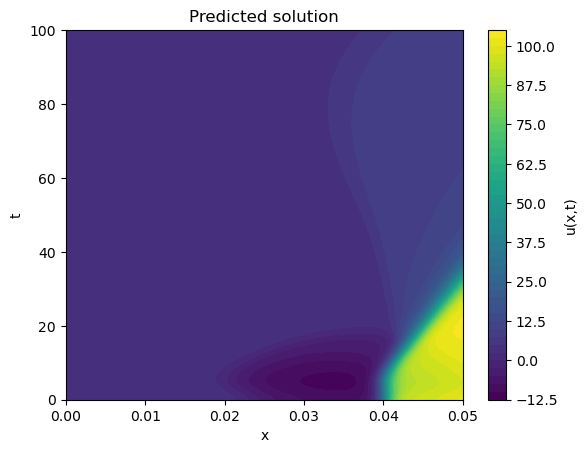

Saving loss history to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\test.dat ...


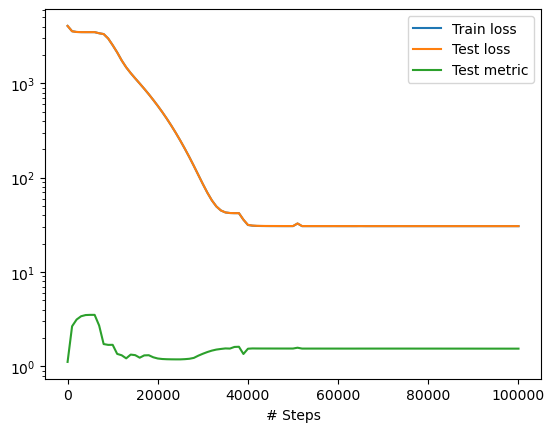

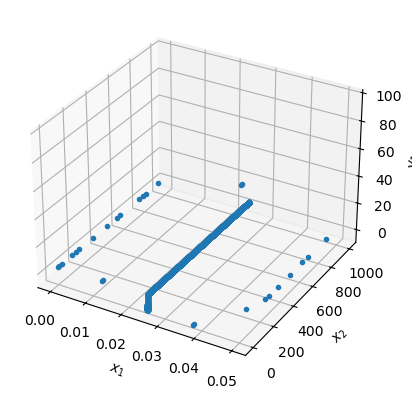

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points to evaluate the solution
x = np.linspace(0, 0.05, 100)
t = np.linspace(0, 100, 100)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution
plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()

# Save the plot and loss history
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [33]:
# Define points where you want to evaluate the solution
points = np.array([[0.5, 0.5], [0, 0.5]])  # Example points (x, t)

# Use the trained model to predict the solution at these points
y_pred = model.predict(points)
print("Predicted solution at points:", y_pred)


ValueError: Cannot feed value of shape (2, 2) for Tensor Placeholder_98:0, which has shape (None, 1)